# Exploratory Data Analysis

In [6]:
import logging
from collections import defaultdict

import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
from functools import reduce
from sqlalchemy import create_engine


USER = 'slee'
PASSWORD = 'o81FQOypVmTp'
HOST = '35.195.247.113'
DB_NAME = 'chai'


class ChaiDB:
    """Class for accessing Chai database. Edit the USER and PASSWORD variables to connect."""

    def __init__(self):
        """Set up the db connection upon initialisation."""
        logging.info('Creating DB connection')
        engine_string = 'postgresql+psycopg2://%s:%s@%s:5432/%s' % \
                        (USER, PASSWORD, HOST, DB_NAME)
        self.engine = create_engine(engine_string, pool_size=5)
        self.engine.raw_connection().set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
        self.connection = self.engine.connect()

    def get_instrument_data(self, instrument):
        """
        Get all instrument data and return in a dataframe.

        :param instrument Name of instrument to get data for e.g. ethylene_nymex_prices
        :return Dataframe containing instrument data, column names date and value
        """
        query = "SELECT date, value FROM new_instrument_data WHERE instrument = '%s' AND source = '%s'" \
                % (instrument, 'DATASCOPE')
        df = pd.read_sql_query(query, self.engine, index_col='date')
        df.columns = ['value']
        return df

    def get_list_datascope_instruments(self):
        """
        Gets the set of instruments we collect data for from Datascope

        :return: list of those instruments
        """
        query = "SELECT distinct(instrument) FROM new_instrument_data WHERE source = 'DATASCOPE'"
        df = pd.read_sql_query(query, self.engine)
        return df['instrument'].tolist()

    def get_predictive_inputs(self):
        """
        Gets the latest predictive inputs from the database

        :return: dictionary of instrument key to list of inputs
        """
        query = "SELECT instrument, input from predictive_input WHERE source = '%s'" % 'DATASCOPE'
        inputs = self.connection.execute(query).fetchall()
        inputs_dict = defaultdict(list)
        for (k, v) in inputs:
            inputs_dict[k].append(v)
        return inputs_dict

    def close_db_connection(self):
        """
        Close the db connection.
        """
        # close DB connection
        logging.info('Closing DB connection')
        self.engine.connect().close()


# if __name__ == "__main__":
#     """Example of how to user the methods in ChaiDB"""
#     db = ChaiDB()
# #     print(db.get_list_datascope_instruments())
# #     print(db.get_predictive_inputs())
# #     print(db.get_instrument_data('cu_lme_stocks').head())
# #     print(db.get_instrument_data('ethylene_nymex_prices').head())
#     db.close_db_connection()

In [2]:
# db = ChaiDB()

predictors = pd.read_csv('pred_inputs.csv')

predict_these = np.unique(predictors['INSTRUMENT'])

def Download_all_the_data():
    # lmao what it says - cos colab can't access the db....
    db = ChaiDB()
    all_instruments = db.get_list_datascope_instruments()
    
    for instrument in all_instruments:
        df = db.get_instrument_data(instrument)
        df.to_csv('Data/' + instrument + '.csv')
    
def from_csv(instrument):
    df = pd.read_csv('Data/' + instrument + '.csv')
    df['date'] = pd.to_datetime(df['date']).dt.date
    df.set_index('date',inplace=True)
    df = df.sort_values(by = 'date')
    df.columns = [instrument]
    return df


In [4]:
def preprocessing(commodity):
    #####################################################################################
    # This ensures chronological order (some time series are NOT in order)              #
    #####################################################################################
    
    prices_df = db.get_instrument_data(commodity)
    prices_df = prices_df.sort_values(by = 'date')
    prices_df.columns = [commodity]
    return prices_df

def get_predictors(commodity, predictors):
    ####################################################################
    # This returns the df containing the values of the commodity to be #
    # predicted as well as that of its predictors.                     #
    #                                                                  #
    # Args:                                                            #
    # 1) commodity: name of the commodity                              #
    # 2) predictors: the dataframe sent by Michael Button              #
    ####################################################################
    
    # get a list of all its predictors
    Pred = list(predictors.loc[predictors['INSTRUMENT'] == commodity]['INPUT'])
    Pred = [p for p in Pred if p != commodity]
    
    # Initialize the dataframe with the commodity we want to predict
    DF = from_csv( commodity )
    
    # Keep adding the predictors
    for predictor in Pred:
        temp_df = from_csv( predictor )
        DF = DF.join(temp_df)
    return DF

def price_to_returns(prices_df):
    # forward fill
    
    prices_df.fillna(method='ffill', inplace = True)
    
    
    for colname in prices_df.columns:
        temp = prices_df.loc[:,colname]
        
        if np.min(temp) <= 0:
            temp = temp - np.min(temp) + 1
        prices_df[colname] = np.log(temp) - np.log(temp.shift(5))

    # drop rows with NaN
    prices_df.dropna(inplace = True)
    return prices_df

In [7]:
AL = get_predictors('al_lme_prices', predictors)

AL = AL.iloc[:,~AL.columns.duplicated()[[0]]].dropna()
datelist = [datetime.datetime.now().date() + datetime.timedelta(days = i)for i in range(AL.shape[0]) ]
AL.index = datelist

AL = price_to_returns(AL)

# AL_train will be used for model selection, AL_test would be used for testing. 
AL_train = AL.iloc[:1000,:]
AL_test = AL.iloc[1000:,:]

In [14]:
AL

,al_lme_prices
2019-08-29,0.039569
2019-08-30,0.057904
2019-08-31,0.063256
2019-09-01,0.056296
2019-09-02,0.000511
2019-09-03,-0.046077
2019-09-04,-0.061803
2019-09-05,-0.082429
2019-09-06,-0.084679
2019-09-07,-0.011927


# Question: What should be our $\mathcal{X}$ in this case? Time. 

In [8]:
import datetime
import scipy.stats
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# Fitting an ARIMA model

In [9]:
AIC = np.ones([5,2,5]) * 10**8

for p in range(5):
    for d in range(2):
        for q in range(5):
            try:
                model = ARIMA(AL_train.fillna(method= 'ffill'), order=(p,d,q), freq = 'D')
                model_fit = model.fit(disp=0)
                AIC[p,d,q] = model_fit.aic
            except:
                pass

/home/sean/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/sean/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/sean/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

In [10]:
AIC

array([[[-3670.50918639, -4233.3968226 , -4530.07886775, -4537.53601422,
         -5185.1090502 ],
        [-4516.98024712, -4517.66010999, -4516.46014921, -4539.19615566,
         -4549.65525943]],

       [[-4630.84330845, -4632.16796396, -4633.90772649, -4762.04545764,
         -5185.74506795],
        [-4517.511738  , -4619.40144274, -4620.62911357, -4718.52116383,
         -4776.48904813]],

       [[-4632.89671368, -4641.91376663, -4694.57607003, -4847.73047604,
         -5183.76124534],
        [-4516.30401046, -4621.32817135, -4719.75999139, -4769.60057889,
         -4776.41777879]],

       [[-4639.14792981, -4645.57184238, -4659.54036801, -4887.04002705,
         -5182.47210163],
        [-4514.61278027, -4545.77233787, -4720.41646526, -4845.42147411,
         -4959.44332785]],

       [[-4649.33703618, -4651.78994127, -4897.16434955, -4896.32291984,
         -5181.4132452 ],
        [-4514.05522253, -4574.01450641, -4781.95633157, -4869.48371885,
         -4845.42559504]]])

(1, 0, 4)


/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


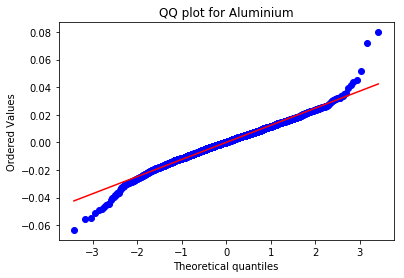

In [11]:
metal = 'Aluminium'
# metal = 'Copper'

ORDER = np.unravel_index(AIC.argmin(), AIC.shape)
print(ORDER)

model = ARIMA(AL_train, order=ORDER, freq = 'D')
model_fit = model.fit(disp=0)

model1 = ARIMA(AL_test, order=ORDER, freq = 'D')
model1.fit(maxiter=0)
A = (model1.predict(params = model_fit.params) - np.array(AL_test).squeeze())

import pylab 
scipy.stats.probplot(A, dist="norm", plot=pylab)
plt.title('QQ plot for '+metal)
plt.show()

Text(0.5,1,'Log of p-values from the Ljungbox Test for Aluminium')

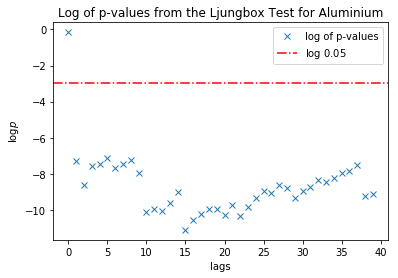

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox


LJUNG = acorr_ljungbox(A, lags=None, boxpierce=True)
plt.plot(np.log(LJUNG[3]), 'x')
plt.axhline(np.log(0.05), color='r', linestyle='-.')

# plt.legend()
plt.gca().legend(('log of p-values',r'log $0.05$'))
plt.xlabel('lags')
plt.ylabel(r'log$p$')
plt.title('Log of p-values from the Ljungbox Test for ' + metal)
# LJUNG


# Print the RMSE and MSE

In [12]:
print(np.sqrt(np.sum(A**2)/len(A)) )
print(np.sum(A**2)/len(A))

0.012493670169351717
0.00015609179430054894


In [623]:
print(ORDER)
print(AIC[ORDER])

(1, 0, 4)
-5185.745067952684


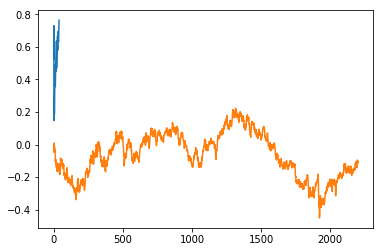

In [35]:
LJUNG_test= acorr_ljungbox(np.random.normal(size = 100), lags=None, boxpierce=True)
plt.plot(LJUNG_test[3])

